In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse


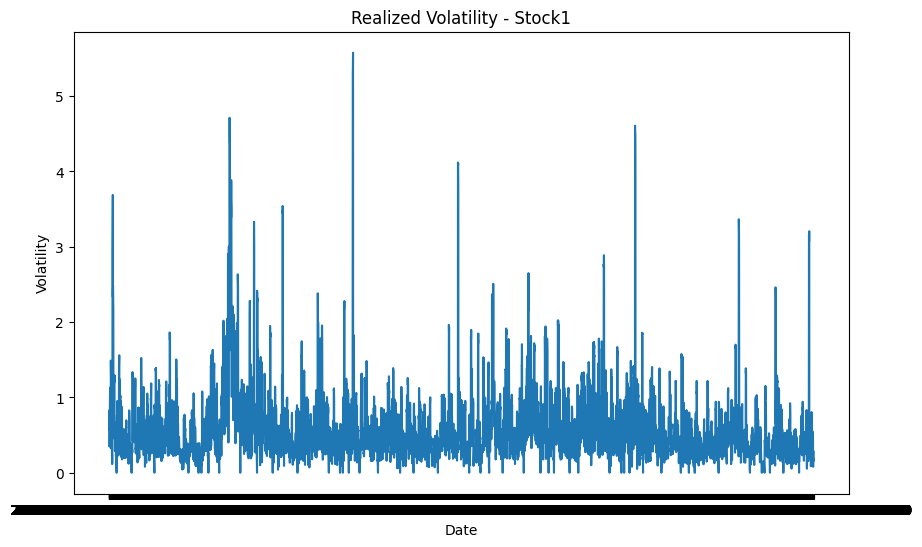

In [9]:


# Load the CSV data
df = pd.read_csv('Price_data.csv')

# Set the 'time' column as the index
df.set_index('Time', inplace=True)

# Select one stock column (e.g., 'stock1')
stock = df['AOS']

# Calculate returns
ret = 100 * stock.pct_change().dropna()

# Calculate rolling realized volatility (e.g., using a 5-period rolling window)
realized_vol = ret.rolling(5).std()

# Plot the realized volatility
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index, realized_vol)
plt.title('Realized Volatility - Stock1')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [19]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Time']

X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

svr_poly = SVR(kernel='poly', degree=2) 
svr_lin = SVR(kernel='linear') 
svr_rbf = SVR(kernel='rbf') 

The RMSE value of SVR with Linear Kernel is 0.000828


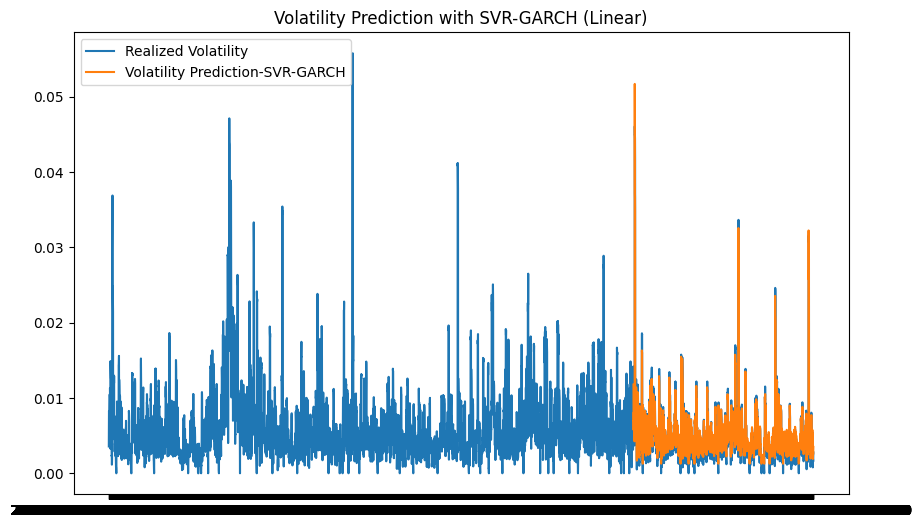

In [23]:
n = 2000
para_grid = {'gamma': sp_rand(),
                      'C': sp_rand(),
                      'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values,
                 realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                                predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
               .format(rmse_svr))

realized_vol.index = ret.iloc[4:].index

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

The RMSE value of SVR with RBF Kernel is  0.001602


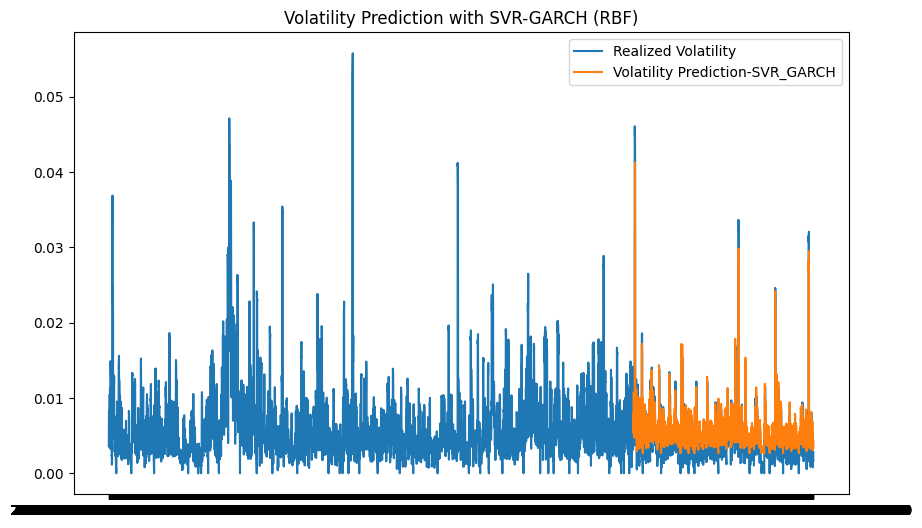

In [24]:
para_grid ={'gamma': sp_rand(),
                     'C': sp_rand(),
                     'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values,
                 realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])


predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                                    predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'
               .format(rmse_svr_rbf))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

In [25]:
para_grid = {'gamma': sp_rand(),
                     'C': sp_rand(),
                     'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid)
clf.fit(X.iloc[:-n].values,
                 realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index

rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                                     predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'
               .format(rmse_svr_poly))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)',
                   fontsize=12)
plt.legend()
plt.show()

The RMSE value of SVR with Polynomial Kernel is 0.002141


KeyboardInterrupt: 

The RMSE value of NN is 0.000984


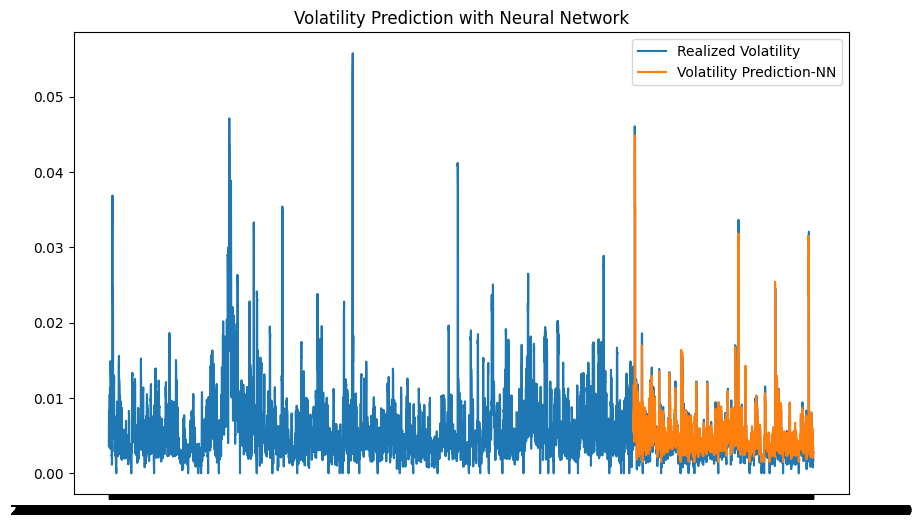

In [26]:
from sklearn.neural_network import MLPRegressor 
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                        'max_iter': [500, 1000],
                        'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values,
                 realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])

NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                               NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
DL_RMSE_1:0.000953
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
DL_RMSE_2:0.000964
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
DL_RMSE_3:0.000945
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
DL_RMSE_4:0.000987


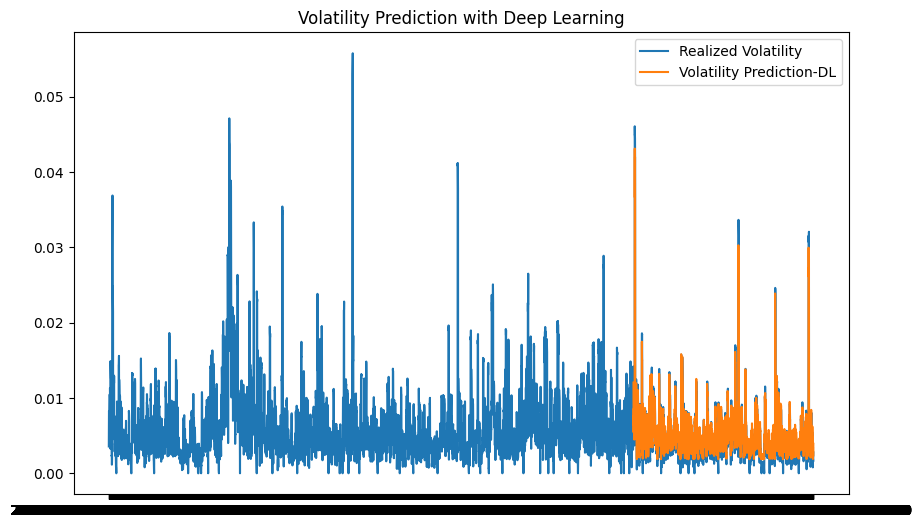

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
             [layers.Dense(256, activation="relu"),
              layers.Dense(128, activation="relu"),
              layers.Dense(1, activation="linear"),])

model.compile(loss='mse', optimizer='rmsprop')

epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
                       realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
                       batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                                     DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))


DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()